# Fama-French Factors Analysis and Sharpe Style Analysis of Fund Returns  
*by Chee-Foong on 2 Dec 2020*  

---

## Summary
Factor analysis decompose observed returns into a set of explantory returns.  In this analysis, we will attempt to decompose the returns of a few selected funds using Fama French Factors.

The **Fama French 3-factor model** is an asset pricing model that expands on the capital asset pricing model by adding size risk and value risk factors to the market risk factors.

The **Fama French 5-factor model** expands the 3-factor model by adding profitability risk and investment risk factors.

Alternatively, we will also explore **Sharpe Style Analysis** in which we will determine the fund's exposures to changes in the returns of major factors.


## Funds
- **BRK-A** - Berkshire Hathaway Inc. Class A share price
- **IUSV** - iShares Core S&P U.S. Value ETF
- **USRT** - iShares Core U.S. REIT ETF
- **SIZE** - iShares MSCI USA Size Factor ETF


## References

1. https://www.investopedia.com/terms/f/famaandfrenchthreefactormodel.asp
2. https://www.etfstream.com/features/is-the-size-factor-broken-no-it-never-existed-in-the-first-place/
3. https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3686583

## Import Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)

import sys  
sys.path.append('../src') 
from edge_risk_kit import *

import edge_risk_kit as erk

In [2]:
import ipywidgets as widgets
from IPython.display import display

In [3]:
import numpy as np
import pandas as pd
from datetime import datetime
import statsmodels.api as sm

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

DATA_FOLDER = '../data/'

## Download Fund Data

In [4]:
tickers = ['BRK-A','IUSV','USRT','SIZE']

start_date = '1900-01-01'
end_date = '2020-12-31'

In [5]:
import yfinance as yf

tickerlist = {}
for ticker in tickers:
    tickerlist[ticker] = yf.Ticker(ticker).info['shortName']
    
data = yf.download(tickers, start=start_date, end=end_date)

[*********************100%***********************]  4 of 4 completed


In [6]:
prices = data['Adj Close'].dropna()
prices.rename(columns={"BRK-A": "BRKA"}, inplace=True)
px_monthly = prices.resample('M').fillna('ffill')
px_monthly.index = px_monthly.index.to_period('M')
rets_monthly = px_monthly.pct_change().dropna()

In [7]:
def plot_perf(fund_name):
    fund_rets = rets_monthly[fund_name]

    dd_fund_rets = erk.drawdown(fund_rets)
    ax = dd_fund_rets["Wealth"].plot(figsize=(12,6), ls='-', color='goldenrod', linewidth=2)
    dd_fund_rets['Previous Peak'].plot(ax=ax, ls=':', color='blue')
    ax.set_title('{} Stock Performance'.format(fund_name))
    plt.show()

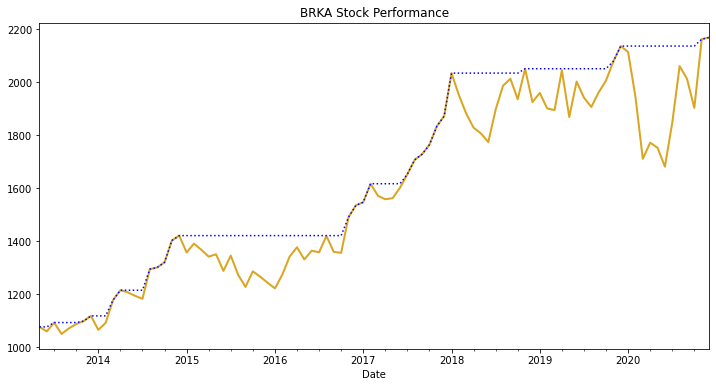

In [8]:
plot_perf('BRKA')

## Download Fama French Data

- https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html

In [9]:
import urllib
import zipfile

ff3_url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_CSV.zip"
ff5_url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_5_Factors_2x3_CSV.zip"
    
zip_path, _ = urllib.request.urlretrieve(ff3_url)
with zipfile.ZipFile(zip_path, "r") as f:
    f.extractall(DATA_FOLDER)
    
zip_path, _ = urllib.request.urlretrieve(ff5_url)
with zipfile.ZipFile(zip_path, "r") as f:
    f.extractall(DATA_FOLDER)    

In [10]:
def process_ff_data(filename):
    fama_french = pd.read_csv(DATA_FOLDER + filename, skiprows=3)
    fama_french.dropna(inplace=True)
    fama_french.rename(columns={fama_french.columns[0]:'date'}, inplace=True)
    fama_french.date = fama_french.date.str.strip()
    fama_french['type'] = fama_french.date.apply(lambda x: 'monthly' if len(str(x).strip()) == 6 else 'annually')
    fama_french_monthly = fama_french[fama_french.type == 'monthly']
    fama_french_monthly.drop('type', axis=1, inplace=True)
    fama_french_monthly.date = pd.to_datetime(fama_french_monthly.date, format="%Y%m")
    fama_french_monthly.set_index('date', inplace=True)
    fama_french_monthly.index = fama_french_monthly.index.to_period('M')
    fama_french_monthly = fama_french_monthly.astype(float)
    fama_french_monthly = fama_french_monthly.div(100)
    return fama_french_monthly

In [11]:
fama_french_3_monthly = process_ff_data('F-F_Research_Data_Factors.CSV')
fama_french_5_monthly = process_ff_data('F-F_Research_Data_5_Factors_2x3.CSV')

## Fama-French 
### 3-Factor Model

The Formula for the Fama French Model Is:
\begin{aligned} &R_{it} - R_{ft} = \alpha_{it} + \beta_1 ( R_{Mt} - R_{ft} ) + \beta_2SMB_t + \beta_3HML_t + \epsilon_{it} \\ &\textbf{where:} \\ &R_{it} = \text{total return of a stock or portfolio } i \text{ at time } t \\ &R_{ft} = \text{risk free rate of return at time } t \\ &R_{Mt} = \text{total market portfolio return at time } t \\ &R_{it} - R_{ft} = \text{expected excess return} \\ &R_{Mt} - R_{ft} = \text{excess return on the market portfolio (index)} \\ &SMB_t = \text{size premium (small minus big)} \\ &HML_t = \text{value premium (high minus low)} \\ &\beta_{1,2,3} = \text{factor coefficients} \\ \end{aligned} 

### 5-Factor Model

The Formula for the Fama French Model Is:
\begin{aligned} &R_{it} - R_{ft} = \alpha_{it} + \beta_1 ( R_{Mt} - R_{ft} ) + \beta_2SMB_t + \beta_3HML_t + \beta_4RMW_t + \beta_5CMA_t + \epsilon_{it} \\ &\textbf{where:} \\ &R_{it} = \text{total return of a stock or portfolio } i \text{ at time } t \\ &R_{ft} = \text{risk free rate of return at time } t \\ &R_{Mt} = \text{total market portfolio return at time } t \\ &R_{it} - R_{ft} = \text{expected excess return} \\ &R_{Mt} - R_{ft} = \text{excess return on the market portfolio (index)} \\ &SMB_t = \text{the return spread of small minus large stocks; size premium (small minus big)} \\ &HML_t = \text{the return spread of cheap minus expensive stocks; value premium (high minus low)} \\ &RMW_t = \text{the return spread of the most profitable firms minus the least profitable} \\ &CMA_t = \text{the return spread of firms that invest conservatively minus aggresively} \\ &\beta_{1,2,3,4,5} = \text{factor coefficients} \\ \end{aligned} 



In [12]:
fama_french_3_monthly.head()

,Mkt-RF,SMB,HML,RF
date,,,,
1926-07,0.0296,-0.0230,-0.0287,0.0022
1926-08,0.0264,-0.0140,0.0419,0.0025
1926-09,0.0036,-0.0132,0.0001,0.0023
1926-10,-0.0324,0.0004,0.0051,0.0032
1926-11,0.0253,-0.0020,-0.0035,0.0031


In [13]:
def famafrench(fund_name, model=3):
    if model == 5:
        fama_french_monthly = fama_french_5_monthly
    else:
        fama_french_monthly = fama_french_3_monthly
        
    data = pd.concat([rets_monthly[fund_name], fama_french_monthly], axis=1).dropna()
    fund_excess = data.loc[:, [fund_name]] - data.loc[:, ['RF']].values
    exp_var = data.loc[:, ['Mkt-RF']]
    exp_var["Value"] = data.loc[:,['HML']]
    exp_var["Size"] = data.loc[:,['SMB']]

    if model == 5:
        exp_var["Profitability"] = data.loc[:,['RMW']]
        exp_var["Investment"] = data.loc[:,['CMA']]
    
    ff_model = erk.regress(fund_excess, exp_var)
    return ff_model.summary()

## Factor Analysis of Berkshire Hathaway (BRKA)

### Fama-French 3-Factor Model

In [14]:
famafrench('BRKA')

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   BRKA   R-squared:                       0.656
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     54.55
Date:                Wed, 02 Dec 2020   Prob (F-statistic):           7.63e-20
Time:                        16:19:27   Log-Likelihood:                 201.05
No. Observations:                  90   AIC:                            -394.1
Df Residuals:                      86   BIC:                            -384.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mkt-RF         0.8404      0.073     11.448      0.000       0.694       0.986
Value          0.4069      0.099      4.107      0.000       0.210       0.604
Size          -0.5467      0.122     -4.495      0.000      -0.788      -0.305
Alpha          0.0013      0.003      0.446      0.657      -0.005       0.007
==============================================================================
Omnibus:                        0.594   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.743   Jarque-Bera (JB):                0.627
Skew:                           0.187   Prob(JB):                        0.731
Kurtosis:                       2.834   Cond. No.                         44.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Interpretations
*&ast;Below numbers may defer with new imported data*

For every dollar invested in Berkshire Hathaway's share:
- 64 cents is exposed to market
- 36 cents in treasury bills
- Long 39 cents in Value Stocks
- Short 39 cents in Growth Stocks
- Long 49 cents in Large Cap Stocks
- Short 49 cents in Small Cap Stocks

Even if you were to replicate the above portfolio, you may still underperform Berkshire Hathaway by 44 basis points per month.

### Rolling 36-Month Regression Analysis

In [15]:
def rolling_regress(fund_name, window, model=3):

    if model == 5:
        fama_french_monthly = fama_french_5_monthly
    else:
        fama_french_monthly = fama_french_3_monthly
        
    data = pd.concat([rets_monthly[fund_name], fama_french_monthly], axis=1).dropna()
    fund_excess = data.loc[:, [fund_name]] - data.loc[:, ['RF']].values
    exp_var = data.loc[:, ['Mkt-RF']]
    exp_var["Value"] = data.loc[:,['HML']]
    exp_var["Size"] = data.loc[:,['SMB']]

    if model == 5:
        exp_var["Profitability"] = data.loc[:,['RMW']]
        exp_var["Investment"] = data.loc[:,['CMA']]
    
    data = pd.concat([fund_excess, exp_var], axis=1).dropna()
    dependent_variable = fund_excess.columns
    independent_variables = exp_var.columns
    
    results = []
    nrow, ncol = data.shape

    for i in range(window, nrow):
        coeff = {}
        subdata = data.iloc[i-window:i]
        result = erk.regress(subdata.loc[:,dependent_variable], subdata.loc[:,independent_variables])
        result = result.params
        for idx in result.index:
            coeff['date'] = subdata.index[-1]
            coeff[idx] = result[idx]
        results.append(coeff)
        
    return pd.DataFrame(results)

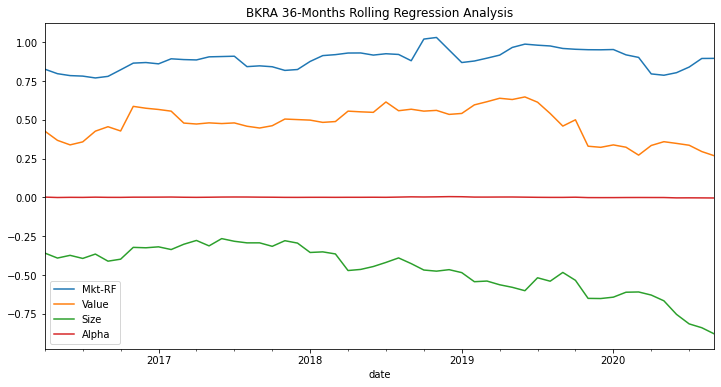

In [16]:
results = rolling_regress('BRKA', 36, 3)
results.set_index('date', inplace=True)
results.plot(figsize=(12,6), title='BKRA 36-Months Rolling Regression Analysis')
plt.show()

### Fama-French 5-Factor Model

Main contributing factors to returns
- Market Excess Returns
- Value Stocks 
- Large Cap Stocks

Contribution from **Profitability** and **Investment** factors are not statistically significant.

In [17]:
famafrench('BRKA', 5)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   BRKA   R-squared:                       0.659
Model:                            OLS   Adj. R-squared:                  0.639
Method:                 Least Squares   F-statistic:                     32.49
Date:                Wed, 02 Dec 2020   Prob (F-statistic):           2.73e-18
Time:                        16:19:28   Log-Likelihood:                 201.53
No. Observations:                  90   AIC:                            -391.1
Df Residuals:                      84   BIC:                            -376.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Mkt-RF            0.8659      0.081     10.686      0.000       0.705       1.027
Value             0.4020      0.129      3.127      0.002       0.146       0.658
Size             -0.4939      0.136     -3.641      0.000      -0.764      -0.224
Profitability     0.0748      0.211      0.355      0.724      -0.345       0.494
Investment        0.2563      0.238      1.075      0.285      -0.218       0.730
Alpha             0.0012      0.003      0.394      0.694      -0.005       0.007
==============================================================================
Omnibus:                        0.208   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.901   Jarque-Bera (JB):                0.314
Skew:                           0.107   Prob(JB):                        0.855
Kurtosis:                       2.806   Cond. No.                         91.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

---
## Factor Analysis - Other Funds
### iShares Core S&P U.S. Value ETF (IUSV)
Main contributing factors to returns
- Market Excess Returns
- Value Stocks 
- Investment Consevative Stocks

Contribution from **Profitability** and **Size** factors are not statistically significant.

In [18]:
famafrench('IUSV',5)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   IUSV   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                     484.7
Date:                Wed, 02 Dec 2020   Prob (F-statistic):           2.29e-60
Time:                        16:19:28   Log-Likelihood:                 313.31
No. Observations:                  90   AIC:                            -614.6
Df Residuals:                      84   BIC:                            -599.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Mkt-RF            0.9489      0.023     40.548      0.000       0.902       0.995
Value             0.2564      0.037      6.906      0.000       0.183       0.330
Size             -0.0146      0.039     -0.373      0.710      -0.093       0.063
Profitability    -0.0830      0.061     -1.361      0.177      -0.204       0.038
Investment        0.1608      0.069      2.336      0.022       0.024       0.298
Alpha            -0.0008      0.001     -0.870      0.387      -0.002       0.001
==============================================================================
Omnibus:                       12.473   Durbin-Watson:                   1.888
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               18.714
Skew:                          -0.588   Prob(JB):                     8.64e-05
Kurtosis:                       4.899   Cond. No.                         91.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### iShares Core U.S. REIT ETF (USRT)
Main contributing factors to returns
- Market Excess Returns
- Value Stocks 

Contribution from **Size**, **Profitability** and **Investment** factors are not statistically significant.

In [19]:
famafrench('USRT', 5)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   USRT   R-squared:                       0.386
Model:                            OLS   Adj. R-squared:                  0.350
Method:                 Least Squares   F-statistic:                     10.58
Date:                Wed, 02 Dec 2020   Prob (F-statistic):           6.72e-08
Time:                        16:19:28   Log-Likelihood:                 171.26
No. Observations:                  90   AIC:                            -330.5
Df Residuals:                      84   BIC:                            -315.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Mkt-RF            0.6393      0.113      5.636      0.000       0.414       0.865
Value            -0.0862      0.180     -0.479      0.633      -0.444       0.272
Size              0.2302      0.190      1.213      0.229      -0.147       0.608
Profitability     0.4016      0.295      1.360      0.177      -0.186       0.989
Investment        0.1654      0.334      0.496      0.621      -0.498       0.829
Alpha            -0.0035      0.004     -0.826      0.411      -0.012       0.005
==============================================================================
Omnibus:                        3.473   Durbin-Watson:                   2.048
Prob(Omnibus):                  0.176   Jarque-Bera (JB):                2.777
Skew:                          -0.335   Prob(JB):                        0.249
Kurtosis:                       3.540   Cond. No.                         91.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### iShares MSCI USA Size Factor ETF
Surprisingly, the main contributing factors to returns are:
- Market Excess Returns
- Value Stocks 
- Robust Profitability Stocks

Contribution from **Size** and **Investment** factors are not statistically significant.

It seems to be true that Size is a weak factor as a standalone factor.  One possible reason being small cap stocks are far more illiquid than their large cap stocks and therefore their market beta are understimated.

In [20]:
famafrench('SIZE', 5)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   SIZE   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.939
Method:                 Least Squares   F-statistic:                     276.2
Date:                Wed, 02 Dec 2020   Prob (F-statistic):           1.40e-50
Time:                        16:19:28   Log-Likelihood:                 287.71
No. Observations:                  90   AIC:                            -563.4
Df Residuals:                      84   BIC:                            -548.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Mkt-RF            0.9277      0.031     29.831      0.000       0.866       0.990
Value             0.1326      0.049      2.687      0.009       0.034       0.231
Size              0.0943      0.052      1.811      0.074      -0.009       0.198
Profitability     0.1882      0.081      2.324      0.023       0.027       0.349
Investment       -0.1153      0.091     -1.261      0.211      -0.297       0.067
Alpha            -0.0005      0.001     -0.394      0.694      -0.003       0.002
==============================================================================
Omnibus:                        3.093   Durbin-Watson:                   2.153
Prob(Omnibus):                  0.213   Jarque-Bera (JB):                2.390
Skew:                          -0.325   Prob(JB):                        0.303
Kurtosis:                       3.464   Cond. No.                         91.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

---

## Sharpe Style Analysis

Sharpe Style Analysis is an elegant and simple decomposition exercise similar to the factor analysis done above, with the added constraint that the coefficients are all positive and add to 1.

Therefore, the coefficients of performing style analysis on the observed return of a manager can be interpreted as weights in a portfolio of building blocks which together, *mimic* that return series. The exercise can reveal drifts in a manager's style as well as provide insight into what the manager is likely doing to obtain the returns.


### Performing Sharpe Style Analysis

The key to obtaining the weights is the quadriatic optimizer.  Objective is to find the weights that minimizes the square of the difference between the observed series and the returns of a benchmark portfolio that holds the explanatory building blocks in those same weights. This is equivalent to minimizing the *tracking error* between the two return series.

In [21]:
def rolling_style(fund_name, window, model=3):

    if model == 5:
        fama_french_monthly = fama_french_5_monthly
    else:
        fama_french_monthly = fama_french_3_monthly
        
    data = pd.concat([rets_monthly[fund_name], fama_french_monthly], axis=1).dropna()
    fund_rets = data.loc[:, [fund_name]]
    exp_var = data.loc[:, ['Mkt-RF']]
    exp_var["RF"] = data.loc[:, ['RF']]
    exp_var["Value"] = data.loc[:,['HML']]
    exp_var["Size"] = data.loc[:,['SMB']]

    if model == 5:
        exp_var["Profitability"] = data.loc[:,['RMW']]
        exp_var["Investment"] = data.loc[:,['CMA']]
    
    data = pd.concat([fund_rets, exp_var], axis=1).dropna()
    dependent_variable = fund_rets.columns
    independent_variables = exp_var.columns
    
    results = []
    nrow, ncol = data.shape

    for i in range(window, nrow):
        coeff = {}
        subdata = data.iloc[i-window:i]
        result = erk.style_analysis(subdata.loc[:,dependent_variable], subdata.loc[:,independent_variables])
        for idx in result.index:
            coeff['date'] = subdata.index[-1]
            coeff[idx] = result[idx]
        results.append(coeff)
        
    return pd.DataFrame(results)

## Style Analysis on Berkshire Hathaway (BRKA)
- on Fama-French 5-Factors

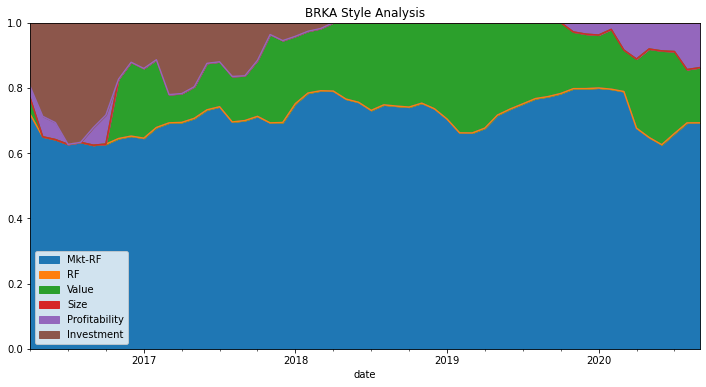

In [22]:
fund_name = 'BRKA'
style_results = rolling_style(fund_name, 36, 5)
style_results.set_index('date', inplace=True)

# We need to transform the data from raw data to percentage (fraction)
style_results_perc = style_results.divide(style_results.sum(axis=1), axis=0)

style_results_perc.plot(kind='area', stacked=True, figsize=(12,6), 
                        title='{} Style Analysis'.format(fund_name), ylim=(0,1))
plt.show()

The plot above shows how the style of Berkshire Hathaway may have evolved over the years based on past 36 months of return data.  Allocating more to value stocks beginning 2017 and switching to more robust profitability stocks in 2020.